<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Strato75/Covid-19_ItalyStats/blob/master/notebooks/per_province_choropleth_diagram.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" />Run in Google Colab</a>
  </td>
</table>

In [ ]:
# Execute this cell to install these required packages if you run it in Google Colab
!pip install geojson
!pip install geopandas
!pip install folium

In [1]:
%pylab inline
import pandas as pd
import requests
import numpy as np
import folium
import pandas as pd
import geopandas as gpd
import geojson 
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_df_from_json_url(url):
    response = requests.get(url)
    df = pd.read_json(response.text, orient='records')
    return df


def get_geojson_from_url(url):
    response = requests.get(url)
    geoj = geojson.loads(response.text)
    return geoj

In [3]:
raw_it_province_df = get_df_from_json_url('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-province.json')
raw_it_province_df['data'] = pd.to_datetime(raw_it_province_df['data'], format='%Y-%m-%d %H:%M:%S')

# Parameters for savgol filter (Smooting curves)
sliding_win_size = 15
polynomial_fit_degree = 3

### Total case trends per province for each region

In [4]:
## Add a column to dataframe to merge P.A. Bolzano and P.A. Trento as single region to simplify mulitplot diagram
raw_it_province_df['new_den_regione'] = raw_it_province_df['denominazione_regione']
raw_it_province_df['new_den_regione'].replace('P.A. Bolzano', 'Trentino-Alto Adige', inplace=True)
raw_it_province_df['new_den_regione'].replace('P.A. Trento', 'Trentino-Alto Adige', inplace=True)

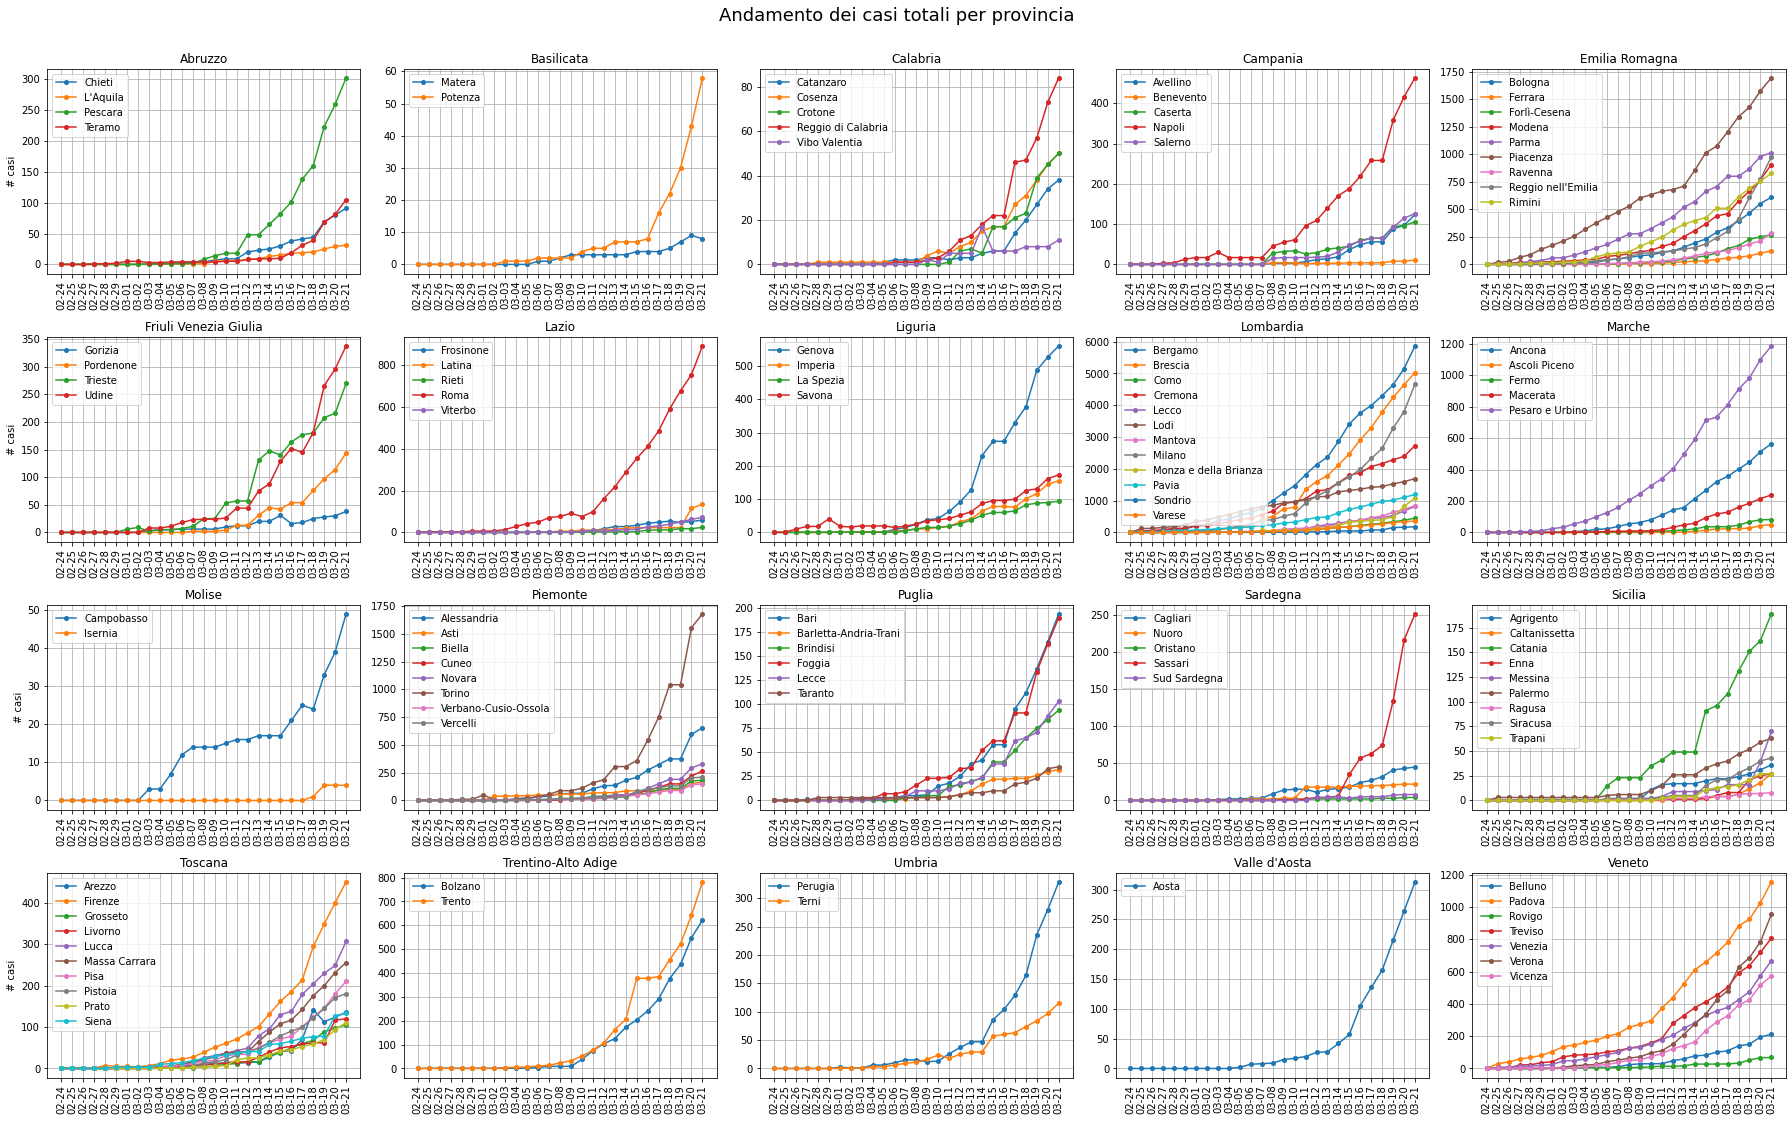

In [5]:
group_by_region = raw_it_province_df.groupby('new_den_regione')

fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25,16))
for index, g in enumerate(group_by_region.groups):
        curr_ax = ax[index//5][index%5]
        reg_df = group_by_region.get_group(g)
        g_by_province = reg_df.groupby('denominazione_provincia')

        for p in g_by_province.groups:
            if 'fase di' not in p:
                prov_df = g_by_province.get_group(p)
                x_data = ['-'.join(i.split('T')[0].split('-')[1:]) for i in np.datetime_as_string(prov_df['data'].values)]
                y_data = prov_df['totale_casi']
                curr_ax.plot(x_data, y_data, 'o-', ms=4, label='%s' % p)

        curr_ax.legend()
        curr_ax.grid()
        curr_ax.set_title(g)
        _ = curr_ax.set_xticklabels(x_data, rotation=90)
        if index%5 == 0:
            curr_ax.set_ylabel('# casi')
plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.suptitle("Andamento dei casi totali per provincia", fontsize=18)
fig.savefig('figures/provinces_trend.png', dpi=300, transparency=False, )

### Choropleth Map

In [6]:
geojson_province_url = 'https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_provinces.geojson'
geoj = get_geojson_from_url(geojson_province_url)
gdf = gpd.GeoDataFrame.from_features(geoj)
gdf['centroid_lon'] = gdf['geometry'].centroid.x
gdf['centroid_lat'] = gdf['geometry'].centroid.y

## Add to geodataframe latitude, longitute and total case fields
# merge with some columns of raw_it_province_df data 
raw_it_province_df_small = raw_it_province_df[['data', 'codice_provincia', 'lat', 'long', 'totale_casi']]
gdf_province = gdf.merge(raw_it_province_df_small, left_on='prov_istat_code_num', right_on='codice_provincia')
group_by_date = gdf_province.groupby('data')
dates = list(group_by_date.groups)

#### Get data from the last day

In [7]:
# Select by date
selected_date = dates[-1] # This select the last day available in the dataframe
gdf_per_date = group_by_date.get_group(selected_date) # Get dataframe by date
groups_by_province = gdf_per_date.groupby('prov_name')
gdf_per_date['totale_casi'].replace(0.0, np.nan, inplace=True) # It makes blank background to provinces with zero cases 

/home/giovanni/.virtualenvs/python3-stat-ML/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [8]:
# create the map
f = folium.Figure(width=650, height=850)

m = folium.Map(location=[np.median(gdf_per_date['centroid_lat'].tolist()), 
                         np.median(gdf_per_date['centroid_lon'].tolist())], 
               tiles='Stamen Toner', zoom_start=6,
               control_scale=True,
               zoom_control=True)

               
## add chloropleth layer
m.choropleth(
    geo_data=geoj,
    name='Totale casi per provincia',
    data=gdf_per_date,
    columns=['prov_name', 'totale_casi'],
    fill_color='YlOrRd',
    key_on='feature.properties.prov_name',
    legend_name='tot_casi_per_provincia al %s' % selected_date.date(),
    nan_fill_color = 'w',
    nan_fill_opacity = 0
)  

gdf_per_date['totale_casi'].replace(np.nan, 0.0, inplace=True) 
 
for prov in groups_by_province.groups:
    if 'In fase di definizione' not in prov:
        ser = groups_by_province.get_group(prov)
        lat = float(ser['lat'])
        long = float(ser['long'])
        tot_cases = int(ser['totale_casi'])
        
        if tot_cases:
            folium.Circle(
            location= [lat, long],
            tooltip='%s: %d' % (prov, tot_cases),
            radius=(30.),
            color='crimson',
            fill=True,
            fill_color='crimson'
            ).add_to(m)

# enable layers to be turned in or out
folium.LayerControl().add_to(m)

f.add_child(m)

# save it
m.save('figures/province_choropleth_map.html') 

/home/giovanni/.virtualenvs/python3-stat-ML/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Hover above red points to get the number of cases of that province

In [9]:
f